In [1]:
# Calcula los sitios patrimonio de la humanidad expuestos al cambio climático

# Importamos librerías
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import geoviews as gv
import holoviews as hv

# Parámetros de mapas
gv.extension("matplotlib")
# Coloca la barra de color horizontal y abajo
def hook(plot, element):
    cax = plot.handles["cax"]
    ax = plot.handles["axis"]
    bbox = ax.get_position()
    l, b, w, h = bbox.x0, bbox.y0, bbox.width, bbox.height
    cax.set_position([l, 0.9*b, w, 0.05*h])
options = { "hooks": [hook], "ylim":(-62,85), "xlim":(-180,180),
    "colorbar": True,  "colorbar_opts": {"orientation": "horizontal"} } 
options_r = { "colorbar": True, "linewidth": 0.4, "hooks": [hook],
    "colorbar_opts": {"orientation": "horizontal"},
    "cmap": "plasma_r", "ylim":(-62,85), "xlim":(-180,180) }
options_m = { "bgcolor": "#ffffcc", "fontscale": 2,
    "aspect": 2.25, "ylim":(-62,85), "xlim":(-180,180) }

options_m_2 = { "bgcolor": "#ffffcc", "fontscale": 0.5,
    "aspect": 2.25, "ylim":(-62,85), "xlim":(-180,180) }

# Parámetros de visualización de tablas
pd.set_option('display.max_colwidth', None)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [2]:
# Datos

# Códigos nacionales
ix  = "ISO_A3"

# Catálogo de datos
path_catalog = "../../Bases_de_datos/Data_catalog.csv"
df_c = pd.read_csv(path_catalog)

# Mapas
#borders_path = ( "../../Bases_de_datos/Mapas/"
#    + "Natural_Earth/ne_50m_admin_0_countries_mod" )
#borders = gpd.read_file(borders_path).drop(
#    columns = [ix] ).set_index("ISO_A3_EH")
#borders.index.name = ix
#borders = borders[ borders["ISO_N3_EH"] != "-99" ]
#borders = borders[ ~borders.index.duplicated() ]

# Mapa
borders_path = ( "../../Bases_de_datos/Mapas/"
    + "UN/UNmap05_shp/BNDA05_CTY.shp" )
borders = gpd.read_file(borders_path)
    #).drop(columns = [ix]).set_index("ISO_A3_EH")
#borders.loc[borders["ISO3CD"]=="xAP", "ISO3CD"] = "IND"
#borders.loc[borders["ISO3CD"]=="xJK", "ISO3CD"] = "PAK"
#borders.loc[borders["ISO3CD"]=="xAC", "ISO3CD"] = "PAK"
#borders.loc[borders["ISO3CD"]=="ESH", "ISO3CD"] = "MAR"
borders = borders.set_index("ISO3CD")
borders.index.name = ix

# Contorno de países
countries = gv.Path( borders[["geometry"]]
    ).opts( linewidth = 0.4, color = "k" )

# Océano
ocean_path = ( "../../Bases_de_datos/Mapas/"
    + "Natural_Earth/ne_50m_ocean" )
ocean = gv.Polygons( gpd.read_file(ocean_path), vdims = "min_zoom"
    ).opts( linewidth = 0, cmap = "Paired")

# World Heritage List
id = "WHC"
# Cargamos el archivo
df = pd.read_excel( "../../" + df_c.loc[df_c["ID"]==id, "Path"].iloc[0]
    + df_c.loc[df_c["ID"]==id, "Filename" ].iloc[0], index_col = "id_no"
    ).sort_index()
# Creamos un punto con las coordenadas.
df["point"] = gpd.points_from_xy(df["longitude"], df["latitude"])
# Creamos un GeoDataFrame.
df = gpd.GeoDataFrame(df, geometry = "point", crs = 4326)
df["geometry"] = df.buffer(1)
df = df.set_geometry("geometry")

# Guardamos el archivo como shapefile
if not os.path.exists("../results/WHC"):
    os.mkdir("../results/WHC/")
    df.set_geometry("point")[ ["name_en", "states_name_en",
        "longitude", "latitude", "point"]
        ].reset_index().to_file("../results/WHC/WHC.shp")

cat_sl = [ "Sea level rise Hotspots, 1995-2014, historical",
    "Sea level rise Hotspots, 2040-2059, SSP2-4.5" ]
# Cargamos los sitios afectados por incremento del nivel del mar
df_s = gpd.read_file("../results/WHC_sea_level_rise").set_index("id_no")
df[ ["Elevation SRTM"] + cat_sl ] = df_s[
    ["elevation", "fl_present", "fl_future"] ]
df[cat_sl] = df[cat_sl].fillna(0).astype(bool)

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_9675/2260328147.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df["geometry"] = df.buffer(1)


In [3]:
# Obtenemos información de los modelos de elevación
'''
# Overriding requests.Session.rebuild_auth to mantain headers when redirected
class SessionWithHeaderRedirection(requests.Session):
    # Sitio de autenticación
    AUTH_HOST = "urs.earthdata.nasa.gov"

    # Inicializar objeto
    def __init__(self, username, password):
        super().__init__()
        self.auth = (username, password)

   # Overrides from the library to keep headers when
   # redirected to or from the NASA auth host.
    def rebuild_auth(self, prepared_request, response):
        headers = prepared_request.headers
        url = prepared_request.url

        if "Authorization" in headers:
            original_parsed = requests.utils.urlparse(response.request.url)
            redirect_parsed = requests.utils.urlparse(url)
            if ( (original_parsed.hostname != redirect_parsed.hostname)
                and redirect_parsed.hostname != self.AUTH_HOST
                and original_parsed.hostname != self.AUTH_HOST ):
                        del headers['Authorization']
                                    
        return
 
# Creamos la columna de elevación
if not "Elevation ASTGTM" in df.columns:
    df["Elevation ASTGTM"] = None

# Credenciales
# Esto debería estar en un archivo .earth_data_credentials
password = "yEixa3Zrrv8nXqt-j"
username = "rodrigoms"

# The url of the file we wish to retrieve
site = ( "https://data.lpdaac.earthdatacloud.nasa.gov/"
    + "lp-prod-protected/ASTGTM.003/" )

# Iteramos para cada sitio con latitud y
# cuya elevación aún no se haya registrado
for row in df[df["longitude"].notnull()
    & df["Elevation ASTGTM"].isnull() ].itertuples():

    # Cambamos a la convención de ASTGTM
    if row.latitude  > 0: lt = "N"
    else                : lt = "S"
    if row.longitude > 0: ln = "E"
    else                : ln = "W"

    # Coordenadas
    nlat = f"{lt}{np.abs(np.floor(row.latitude)).astype(int):02}"
    nlon = f"{ln}{np.abs(np.floor(row.longitude)).astype(int):03}"

    # URL a descargar
    filename = f"ASTGTMV003_{nlat}{nlon}_dem.tif"

    # Solo descargamos si no existe en la computadora
    if not os.path.exists(f"../temp/ASTGTMV003/{filename}"):
        url = f"{site}{filename}"
        # create session with the user credentials that will 
        # be used to authenticate access to the data
        session = SessionWithHeaderRedirection(username, password)
        # Guardamos el archivo
        with open(f"../temp/ASTGTMV003/{filename}", 'wb') as f:
            f.write( session.get(url).content )
    
    # Verificamos que realmente sea un archivo válido
    if os.stat(f"../temp/ASTGTMV003/{filename}").st_size > 2000:
        # Seleccionamos la elevación correspondiente
        df.loc[row.Index, "Elevation ASTGTM"] = xr.open_dataarray(
            f"../temp/ASTGTMV003/{filename}", engine = "rasterio" ).sel(
            x = row.longitude, y = row.latitude, method = "nearest").values[0]
'''

'\n# Overriding requests.Session.rebuild_auth to mantain headers when redirected\nclass SessionWithHeaderRedirection(requests.Session):\n    # Sitio de autenticación\n    AUTH_HOST = "urs.earthdata.nasa.gov"\n\n    # Inicializar objeto\n    def __init__(self, username, password):\n        super().__init__()\n        self.auth = (username, password)\n\n   # Overrides from the library to keep headers when\n   # redirected to or from the NASA auth host.\n    def rebuild_auth(self, prepared_request, response):\n        headers = prepared_request.headers\n        url = prepared_request.url\n\n        if "Authorization" in headers:\n            original_parsed = requests.utils.urlparse(response.request.url)\n            redirect_parsed = requests.utils.urlparse(url)\n            if ( (original_parsed.hostname != redirect_parsed.hostname)\n                and redirect_parsed.hostname != self.AUTH_HOST\n                and original_parsed.hostname != self.AUTH_HOST ):\n                        

In [4]:
# Asignamos a cada sitio el valor que le corresponde a su coordenada

# Datos climáticos
c_path = "../share/Climate/"
c_files = os.listdir(c_path)
categories = [ "Drought", "Extreme_temperature",
    "Extreme_rainfall", "Hurricane" ]
cat_var   = []
cat_col_h = []
cat_col_f = []

# Iteramos para cada categoría climática
for cat in categories:
    # Cargamos archivos climáticos históricos y futuros
    ds_h = xr.open_dataset(c_path + f"{cat}_1995_2014.nc")
    ds_f = xr.open_dataset(c_path + f"{cat}_2040_2059_SSP245.nc")
    vars = list(ds_h.variables)
    vars.remove("lat")
    vars.remove("lon")
    cat_var.append(vars)

    # Agregamos los nombres de las columnas
    cols_h = ( [ f"{vars[0]}, 1995-2014, historical" ]
        + [ f"{cat.replace("_", " ")} {x}, 1995-2014, historical"
        for x in vars[1:] ] )
    cols_f = ( [ f"{vars[0]}, 2040-2059, SSP2-4.5" ]
        + [ f"{cat.replace("_", " ")} {x}, 2040-2059, SSP2-4.5"
        for x in vars[1:] ] )
    df[cols_h] = None
    df[cols_f] = None
    cat_col_h.append(cols_h)
    cat_col_f.append(cols_f)

    # Iteramos para cada coordenada y asignamos los valores
    for row in df.itertuples():
        vals_h = ds_h.sel( lat = row.latitude,
            lon = row.longitude, method = "nearest" )
        vals_f = ds_f.sel( lat = row.latitude,
            lon = row.longitude, method = "nearest" )
        # Determinamos si el sitio está afectado o no
        for i in range(0, len(cols_h)):
            if i == 1:
                df.loc[row.Index, cols_h[i]] = bool(vals_h[vars[i]].values + 0)
                df.loc[row.Index, cols_f[i]] = bool(vals_f[vars[i]].values + 0)
            else:
                df.loc[row.Index, cols_h[i]] = vals_h[vars[i]].values + 0
                df.loc[row.Index, cols_f[i]] = vals_f[vars[i]].values + 0

In [5]:
# Sitios culturales
v = "cultural"

# Seleccionamos los sitios que no estaban expuestos y lo estarán
columns = [ "name_en", "states_name_en", "region_en",
    "category", "danger", "geometry" ]
cultural = df.loc[ df["category"].isin([v.capitalize()]) &
        ( ( df[cat_col_f[0][1]] & ~df[cat_col_h[0][1]] )
        | ( df[cat_col_f[1][1]] & ~df[cat_col_h[1][1]] )
        | ( df[cat_col_f[2][1]] & ~df[cat_col_h[2][1]] )
        | ( df[cat_col_f[3][1]] & ~df[cat_col_h[3][1]] )
        | ( df[cat_sl[1]      ] & ~df[cat_sl[0]      ] ) ),
        columns + [ cat_col_f[0][0], cat_col_f[1][0],
        cat_col_f[2][0], cat_col_f[3][0], cat_sl[0] ]
        + [ cat_col_f[0][1], cat_col_f[1][1],
        cat_col_f[2][1], cat_col_f[3][1], cat_sl[1] ] ]
cultural["Count"] = cultural.iloc[:, -5:].sum(axis = 1)

# Resumen de estadísticas
print( f"{v.capitalize()} sites at risk from climate change: "
    + f"{cultural.shape[0]}" )
n = df.loc[ df["category"].isin([v.capitalize()]) ].shape[0]
n2 = 100 * cultural.shape[0] / n
print(f"% {v} sites at risk from climate change: {n2:.1f}%")
n3 = df.loc[ df["category"].isin([v.capitalize()])
    & df["danger"].isin([1]) ].shape[0]
n4 = cultural[ cultural["danger"].isin([1]) ].shape[0]
print(f"Endangered {v} sites at risk from climate change: {n4}")
if n3 > 0:
    n5 = 100 * n4 / n3
    print(f"% endangered {v} sites at risk from climate change: {n5:.1f}%")

# Resumen regional
regions = cultural.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

Cultural sites at risk from climate change: 196
% cultural sites at risk from climate change: 21.0%
Endangered cultural sites at risk from climate change: 13
% endangered cultural sites at risk from climate change: 32.5%


,Region,Number of sites
0,Africa,14
1,Arab States,55
2,Asia and the Pacific,37
3,Europe and North America,62
4,Latin America and the Caribbean,28


In [6]:
# Sitios mixtos
v = "mixed"

# Seleccionamos los sitios que no estaban expuestos y lo estarán
columns = [ "name_en", "states_name_en", "region_en",
    "category", "danger", "geometry" ]
mixed = df.loc[ df["category"].isin([v.capitalize()]) &
        ( ( df[cat_col_f[0][1]] & ~df[cat_col_h[0][1]] )
        | ( df[cat_col_f[1][1]] & ~df[cat_col_h[1][1]] )
        | ( df[cat_col_f[2][1]] & ~df[cat_col_h[2][1]] )
        | ( df[cat_col_f[3][1]] & ~df[cat_col_h[3][1]] )
        | ( df[cat_sl[1]      ] & ~df[cat_sl[0]      ] ) ),
        columns + [ cat_col_f[0][0], cat_col_f[1][0],
        cat_col_f[2][0], cat_col_f[3][0], cat_sl[0] ]
        + [ cat_col_f[0][1], cat_col_f[1][1],
        cat_col_f[2][1], cat_col_f[3][1], cat_sl[1] ] ]
mixed["Count"] = mixed.iloc[:, -5:].sum(axis = 1)

# Resumen de estadísticas
print( f"{v.capitalize()} sites at risk from climate change: "
    + f"{mixed.shape[0]}" )
n = df.loc[ df["category"].isin([v.capitalize()]) ].shape[0]
n2 = 100 * mixed.shape[0] / n
print(f"% {v} sites at risk from climate change: {n2:.1f}%")
n3 = df.loc[ df["category"].isin([v.capitalize()])
    & df["danger"].isin([1]) ].shape[0]
n4 = mixed[ mixed["danger"].isin([1]) ].shape[0]
print(f"Endangered {v} sites at risk from climate change: {n4}")
if n3 > 0:
    n5 = 100 * n4 / n3
    print(f"% endangered {v} sites at risk from climate change: {n5:.1f}%")

# Resumen regional
regions = mixed.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

Mixed sites at risk from climate change: 7
% mixed sites at risk from climate change: 17.9%
Endangered mixed sites at risk from climate change: 0


,Region,Number of sites
0,Arab States,1
1,Asia and the Pacific,1
2,Europe and North America,3
3,Latin America and the Caribbean,2


In [7]:
# Sitios naturales
v = "natural"

# Seleccionamos los sitios que no estaban expuestos y lo estarán
columns = [ "name_en", "states_name_en", "region_en",
    "category", "danger", "geometry" ]
natural = df.loc[ df["category"].isin([v.capitalize()]) &
        ( ( df[cat_col_f[0][1]] & ~df[cat_col_h[0][1]] )
        | ( df[cat_col_f[1][1]] & ~df[cat_col_h[1][1]] )
        | ( df[cat_col_f[2][1]] & ~df[cat_col_h[2][1]] )
        | ( df[cat_col_f[3][1]] & ~df[cat_col_h[3][1]] )
        | ( df[cat_sl[1]      ] & ~df[cat_sl[0]      ] ) ),
        columns + [ cat_col_f[0][0], cat_col_f[1][0],
        cat_col_f[2][0], cat_col_f[3][0], cat_sl[0] ]
        + [ cat_col_f[0][1], cat_col_f[1][1],
        cat_col_f[2][1], cat_col_f[3][1], cat_sl[1] ] ]
natural["Count"] = natural.iloc[:, -5:].sum(axis = 1)

# Resumen de estadísticas
print( f"{v.capitalize()} sites at risk from climate change: "
    + f"{natural.shape[0]}" )
n = df.loc[ df["category"].isin([v.capitalize()]) ].shape[0]
n2 = 100 * natural.shape[0] / n
print(f"% {v} sites at risk from climate change: {n2:.1f}%")
n3 = df.loc[ df["category"].isin([v.capitalize()])
    & df["danger"].isin([1]) ].shape[0]
n4 = natural[ natural["danger"].isin([1]) ].shape[0]
print(f"Endangered {v} sites at risk from climate change: {n4}")
if n3 > 0:
    n5 = 100 * n4 / n3
    print(f"% endangered {v} sites at risk from climate change: {n5:.1f}%")

# Resumen regional
regions = natural.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

Natural sites at risk from climate change: 35
% natural sites at risk from climate change: 15.4%
Endangered natural sites at risk from climate change: 2
% endangered natural sites at risk from climate change: 12.5%


,Region,Number of sites
0,Africa,5
1,Arab States,3
2,Asia and the Pacific,5
3,Europe and North America,10
4,Latin America and the Caribbean,12


:Overlay
   .Polygons.I                                       :Polygons   [Longitude,Latitude]   (min_zoom)
   .Path.I                                           :Path   [Longitude,Latitude]
   .Polygons.Site_exposed_to_3_kinds_of_climate_risk :Polygons   [Longitude,Latitude]   (Count)
   .Polygons.Site_exposed_to_2_kinds_of_climate_risk :Polygons   [Longitude,Latitude]   (Count)
   .Polygons.Site_exposed_to_1_kind_of_climate_risk  :Polygons   [Longitude,Latitude]   (Count)
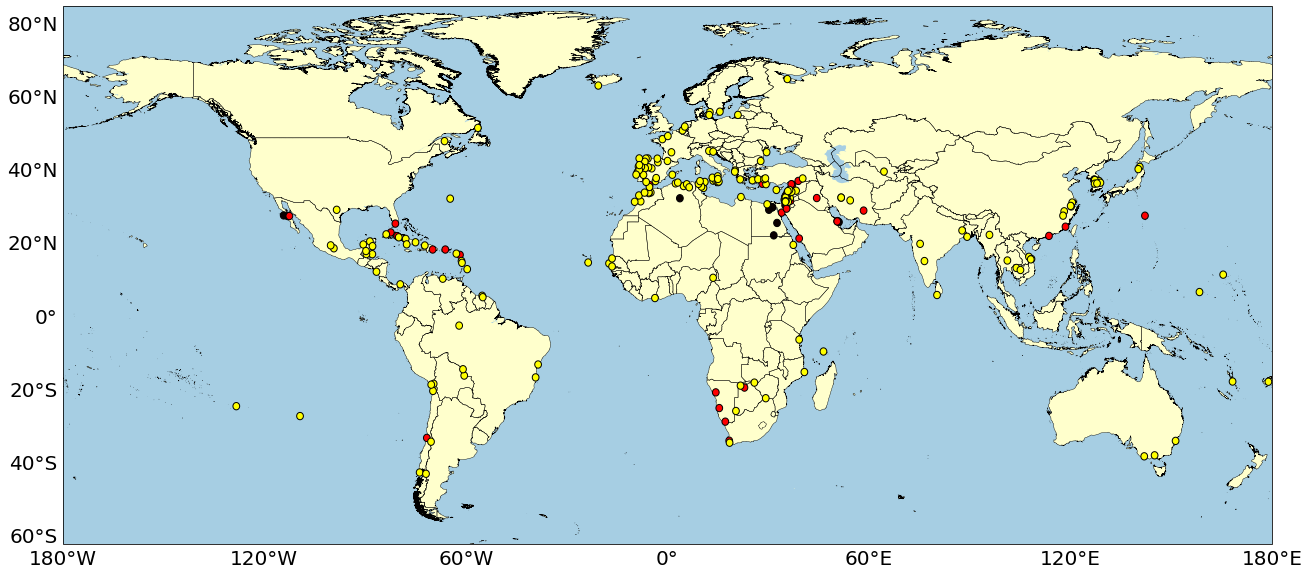

World Heritage Sites at risk from climate change: 238
% World Heritage Sites at risk from climate change: 104.8%
Endangered World Heritage Sites at risk from climate change: 15
% Endangered World Heritage Sites at risk from climate change: 93.8%
World Heritage Sites exposed to 3 kinds of climate risk (purple points): 12
World Heritage Sites exposed to 2 kinds of climate risk (red points): 32
World Heritage Sites exposed to 1 kind of climate risk (yellow points): 193


,Region,Number of sites
0,Africa,19
1,Arab States,59
2,Asia and the Pacific,43
3,Europe and North America,75
4,Latin America and the Caribbean,42


In [9]:
# Sitios afectados por cambio climático

# Guardamos el archivo
clim = pd.concat([cultural, natural, mixed])
clim.to_csv("../share/Indexes/WHC_sites.csv")

# Mapa
# Diferentes objetos agrupados por cantidad de categorías afectadas
count_1 = clim[clim["Count"] == 1]
map_1 = gv.Polygons( count_1, vdims = "Count",
    label = "Site exposed to 1 kind of climate risk"
    ).options(cmap = "autumn_r")
count_2 = clim[clim["Count"] == 2]
map_2 = gv.Polygons( count_2, vdims = "Count",
    label = "Site exposed to 2 kinds of climate risk"
    ).options(cmap = "autumn")
count_3 = clim[clim["Count"] == 3]
map_3 = gv.Polygons( count_3, vdims = "Count",
    label = "Site exposed to 3 kinds of climate risk"
    ).options(cmap = "hot")
map = ( ocean * countries * map_3 * map_2 * map_1 ).opts( show_legend = True,
    #title = "World Heritage Sites at Risk from Climate Change",
    **options_m )
gv.output( map, size = 600 )
count_1 = clim[clim["Count"] == 1]
map_1 = gv.Polygons( count_1, vdims = "Count",
    label = "Site exposed to 1 kind of climate risk"
    ).options(cmap = "autumn_r", linewidth = 0.15)
count_2 = clim[clim["Count"] == 2]
map_2 = gv.Polygons( count_2, vdims = "Count",
    label = "Site exposed to 2 kinds of climate risk"
    ).options(cmap = "autumn", linewidth = 0.15)
count_3 = clim[clim["Count"] == 3]
map_3 = gv.Polygons( count_3, vdims = "Count",
    label = "Site exposed to 3 kinds of climate risk"
    ).options(cmap = "hot", linewidth = 0.15)
# Contorno de países
borders.loc["ISR", "geometry"] = borders.loc[
    ["PSE", "ISR"]].dissolve().loc[0,"geometry"]
countries_2 = gv.Path( borders.drop("PSE")[["geometry"]]
    ).opts( linewidth = 0.02, color = "k" )
countries_3 = gv.Path( borders.loc["PSE"][["geometry"]]
    ).opts( linewidth = 0.02, color = "k", linestyle="dotted" )
map = ( ocean * countries_2 * countries_3 * map_3 * map_2 * map_1
    ).opts( show_legend = True,
    #title = "World Heritage Sites at Risk from Climate Change",
    **options_m_2 )
hv.render(map).savefig("../graphs/WHC_climate.png",
    bbox_inches = "tight", dpi = 3000 )

# Resumen de estadísticas
print( f"World Heritage Sites at risk from climate change: "
    + f"{clim.shape[0]}" )
n = df.loc[ df["category"].isin([v.capitalize()]) ].shape[0]
n2 = 100 * clim.shape[0] / n
print(f"% World Heritage Sites at risk from climate change: {n2:.1f}%")
n3 = df.loc[ df["category"].isin([v.capitalize()])
    & df["danger"].isin([1]) ].shape[0]
n4 = clim[ clim["danger"].isin([1]) ].shape[0]
print(f"Endangered World Heritage Sites at risk from climate change: {n4}")
if n3 > 0:
    n5 = 100 * n4 / n3
    print( "% Endangered World Heritage Sites at risk from climate change: "
        + f"{n5:.1f}%" )
print( "World Heritage Sites exposed to 3 kinds of "
    + f"climate risk (purple points): {count_3.shape[0]}" )
print( "World Heritage Sites exposed to 2 kinds of "
    + f"climate risk (red points): {count_2.shape[0]}" )
print( "World Heritage Sites exposed to 1 kind of "
    + f"climate risk (yellow points): {count_1.shape[0]}" )

# Resumen regional
regions = clim.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

In [9]:
# Resumen regional
# Sitios afectados por 1 categoría
regions = count_1.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

,Region,Number of sites
0,Africa,14
1,Arab States,39
2,Asia and the Pacific,38
3,Europe and North America,68
4,Latin America and the Caribbean,34


In [10]:
# Resumen regional
# Sitios afectados por 2 categorías
regions = count_2.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

,Region,Number of sites
0,Africa,5
1,Arab States,11
2,Asia and the Pacific,4
3,Europe and North America,6
4,Latin America and the Caribbean,6


In [11]:
# Resumen regional
# Sitios afectados por 3 categorías
regions = count_3.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

,Region,Number of sites
0,Arab States,9
1,Europe and North America,1
2,Latin America and the Caribbean,2


:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (min_zoom)
   .Path.I      :Path   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]   (danger)
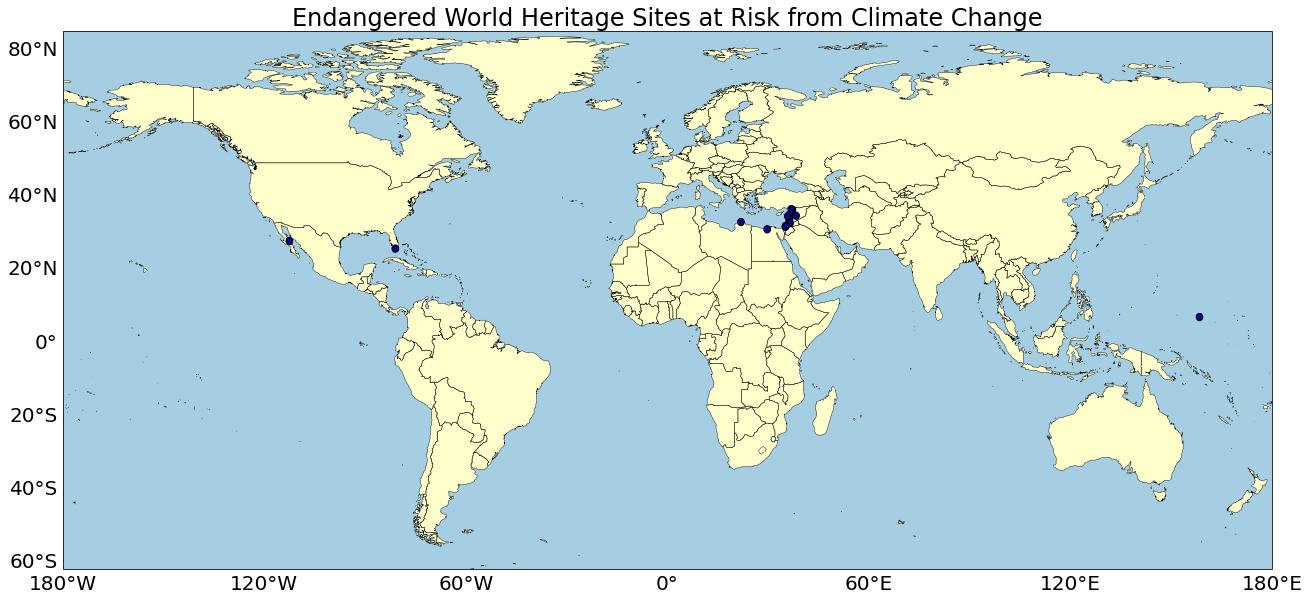

,Name,States,Category,Drought,Extreme heat,Extreme rainfall,Strong Hurricanes,Sea level rise
0,Ancient City of Aleppo,Syrian Arab Republic,Cultural,Yes,Yes,No,No,No
1,Ancient Villages of Northern Syria,Syrian Arab Republic,Cultural,Yes,Yes,No,No,No
2,Everglades National Park,United States of America,Natural,No,No,No,Yes,Yes
3,Islands and Protected Areas of the Gulf of California,Mexico,Natural,No,No,Yes,Yes,No
4,Ancient City of Damascus,Syrian Arab Republic,Cultural,Yes,No,No,No,No
5,Ancient City of Bosra,Syrian Arab Republic,Cultural,Yes,No,No,No,No
6,Site of Palmyra,Syrian Arab Republic,Cultural,No,Yes,No,No,No
7,Abu Mena,Egypt,Cultural,Yes,No,No,No,No
8,Old City of Jerusalem and its Walls,Jerusalem (Site proposed by Jordan),Cultural,Yes,No,No,No,No
9,Archaeological Site of Cyrene,Libya,Cultural,Yes,No,No,No,No


In [12]:
# Sitios amezadaos afectados por cambio climático

# Mapa
min_v, max_v = -0.25, 1
danger = pd.concat( [ cultural[cultural["danger"]==1],
    mixed[mixed["danger"]==1], natural[natural["danger"]==1] ] )
map_danger = gv.Polygons( danger, vdims =  gv.Dimension( "danger",
    range = ( min_v, max_v ) ) ).opts( cmap = "plasma_r",
    ylim = (-62,85), xlim = (-180,180) )
map = ( ocean * countries * map_danger ).opts(
    title = "Endangered World Heritage Sites at Risk from Climate Change",
    **options_m )
gv.output( map, size = 600 )

# Tabla con sitios más afectados
c = [ "Drought Hotspots, 2040-2059, SSP2-4.5",
    "Extreme temperature Hotspots, 2040-2059, SSP2-4.5",
    "Extreme rainfall Hotspots, 2040-2059, SSP2-4.5",
    "Hurricane Hotspots, 2040-2059, SSP2-4.5",
    "Sea level rise Hotspots, 2040-2059, SSP2-4.5" ]
c_2 = [ "Drought", "Extreme heat", "Extreme rainfall",
    "Strong Hurricanes", "Sea level rise" ]
disp = danger.sort_values("Count", ascending = False
    ).reset_index(drop = True)
disp = disp[ [ "name_en", "states_name_en", "category" ] + c ]
disp.columns = [ "Name", "States", "Category" ] + c_2
disp[c_2] = disp[c_2].where( disp[c_2], "No" )
disp[c_2] = disp[c_2].where( disp[c_2] == "No", "Yes" )
disp

In [13]:
# Resumen regional
regions = danger.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

,Region,Number of sites
0,Arab States,12
1,Asia and the Pacific,1
2,Europe and North America,1
3,Latin America and the Caribbean,1


0, -0.3605765104293823, -0.15129782259464264


:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (min_zoom)
   .Path.I      :Path   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]   (SPEI-12, 2040-2059, SSP2-4.5)
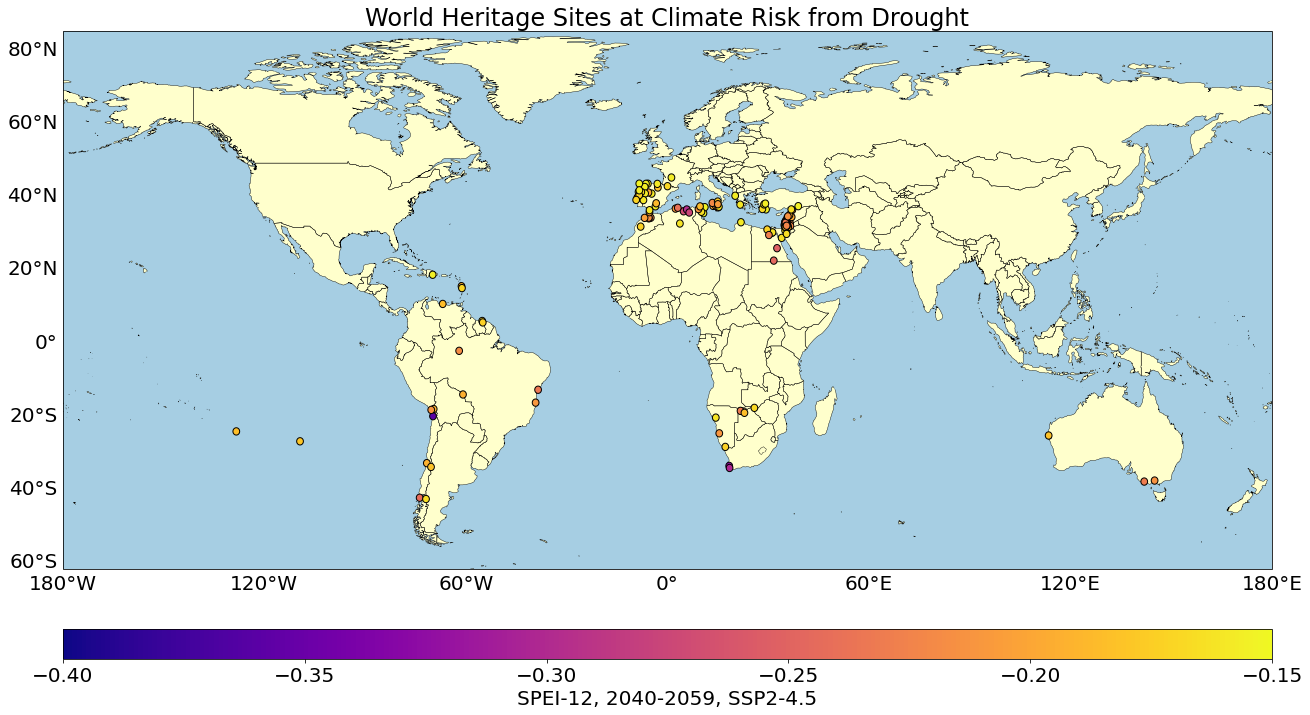

,Name,States,Category,Endangered,SPEI-12
0,Humberstone and Santa Laura Saltpeter Works,Chile,Cultural,No,-0.36
1,Robben Island,South Africa,Cultural,No,-0.33
2,Cape Floral Region Protected Areas,South Africa,Natural,No,-0.30
3,Djémila,Algeria,Cultural,No,-0.30
4,Timgad,Algeria,Cultural,No,-0.28
5,Al Qal'a of Beni Hammad,Algeria,Cultural,No,-0.27
6,Ancient Thebes with its Necropolis,Egypt,Cultural,No,-0.25
7,Nubian Monuments from Abu Simbel to Philae,Egypt,Cultural,No,-0.25
8,Churches of Chiloé,Chile,Cultural,No,-0.24
9,"Biblical Tels - Megiddo, Hazor, Beer Sheba",Israel,Cultural,No,-0.24


In [14]:
# Sitios afectados por sequía
i = 0

# Mapa
clim = pd.concat( [ cultural[cultural[cat_col_f[i][1]]],
    mixed[mixed[cat_col_f[i][1]]], natural[natural[cat_col_f[i][1]]] ] )
print(f"{i}, {clim[cat_col_f[i][0]].min()}, {clim[cat_col_f[i][0]].max()}")
min_v, max_v = -0.40, -0.15
map_clim = gv.Polygons( clim, vdims = gv.Dimension( cat_col_f[i][0],
    range = ( min_v, max_v ) ) ).opts( cmap = "plasma", **options )
map = ( ocean * countries * map_clim ).opts(
    title = "World Heritage Sites at Climate Risk from Drought",
    **options_m )
gv.output( map, size = 600 )

# Tabla con sitios más afectados
disp = clim.sort_values( cat_col_f[i][0], ascending = True
    ).reset_index(drop = True).head(10).copy()
disp = disp[ [ "name_en", "states_name_en",
    "category", "danger", cat_col_f[i][0] ] ]
disp.columns = [ "Name", "States",
    "Category", "Endangered", cat_col_f[i][0][:-21] ]
disp["Endangered"] = disp["Endangered"].where(
    disp["Endangered"] == 1, "No" )
disp["Endangered"] = disp["Endangered"].where(
    disp["Endangered"] == "No", "Yes" )
disp = disp.style.format( {cat_col_f[i][0][:-21]: "{:.2f}"} )
disp

In [15]:
# Resumen regional
regions = clim.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

,Region,Number of sites
0,Africa,8
1,Arab States,49
2,Asia and the Pacific,3
3,Europe and North America,48
4,Latin America and the Caribbean,17


1, 84.900016784668, 200.75


:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (min_zoom)
   .Path.I      :Path   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]   (Days above 35°C, 2040-2059, SSP2-4.5)
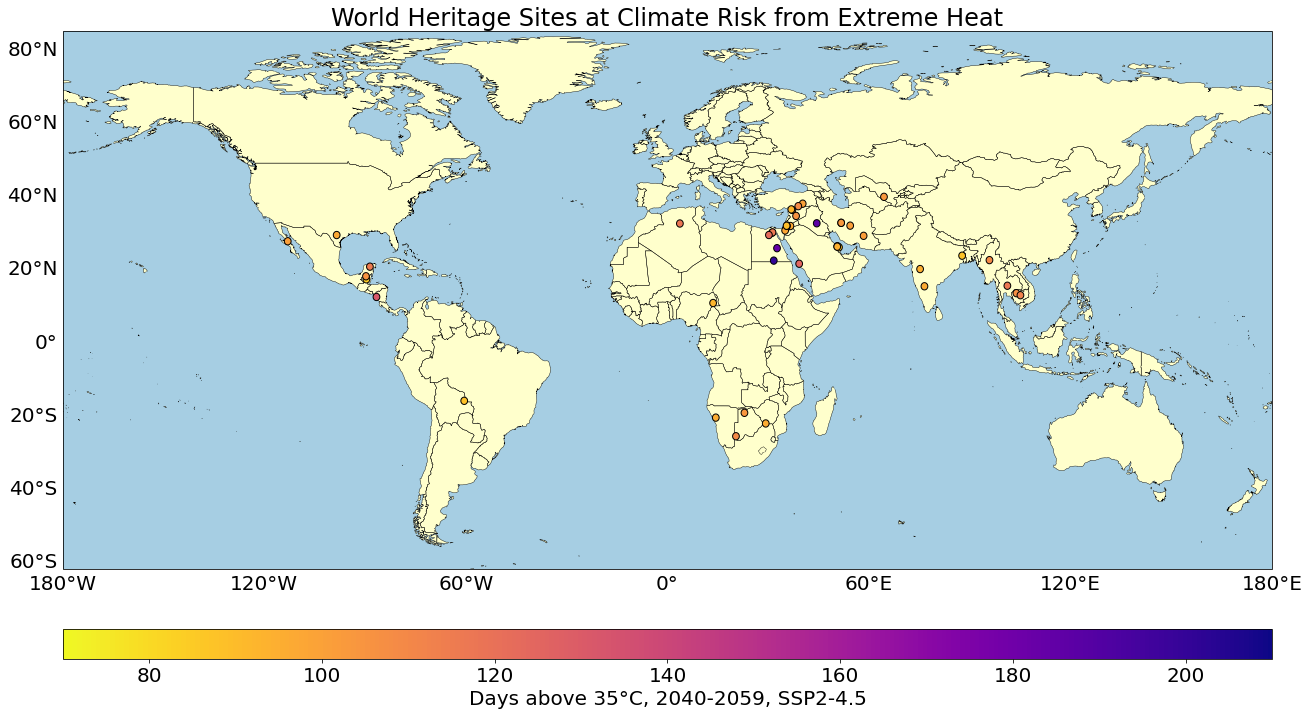

,Name,States,Category,Endangered,Days above 35°C
0,Nubian Monuments from Abu Simbel to Philae,Egypt,Cultural,No,201
1,Babylon,Iraq,Cultural,No,187
2,Ancient Thebes with its Necropolis,Egypt,Cultural,No,184
3,Ruins of León Viejo,Nicaragua,Cultural,No,132
4,"Historic Jeddah, the Gate to Makkah",Saudi Arabia,Cultural,No,125
5,Wadi Al-Hitan (Whale Valley),Egypt,Natural,No,122
6,M'Zab Valley,Algeria,Cultural,No,118
7,Masada,Israel,Cultural,No,117
8,The Ancient Town of Si Thep and its Associated Dvaravati Monuments,Thailand,Cultural,No,117
9,Historic Cairo,Egypt,Cultural,No,116


In [16]:
# Sitios afectados por calor extremo
i = 1

# Mapa
clim = pd.concat( [ cultural[cultural[cat_col_f[i][1]]],
    mixed[mixed[cat_col_f[i][1]]], natural[natural[cat_col_f[i][1]]] ] )
print(f"{i}, {clim[cat_col_f[i][0]].min()}, {clim[cat_col_f[i][0]].max()}")
min_v, max_v = 70, 210
map_clim = gv.Polygons( clim, vdims = gv.Dimension( cat_col_f[i][0],
    range = ( min_v, max_v ) ) ).opts( cmap = "plasma_r", **options )
map = ( ocean * countries * map_clim ).opts(
    title = "World Heritage Sites at Climate Risk from Extreme Heat",
    **options_m )
gv.output( map, size = 600 )

# Tabla con sitios más afectados
disp = clim.sort_values( cat_col_f[i][0], ascending = False
    ).reset_index(drop = True).head(10).copy()
disp = disp[ [ "name_en", "states_name_en",
    "category", "danger", cat_col_f[i][0] ] ]
disp.columns = [ "Name", "States",
    "Category", "Endangered", cat_col_f[i][0][:-21] ]
disp["Endangered"] = disp["Endangered"].where(
    disp["Endangered"] == 1, "No" )
disp["Endangered"] = disp["Endangered"].where(
    disp["Endangered"] == "No", "Yes" )
disp = disp.style.format( {cat_col_f[i][0][:-21]: "{:.0f}"} )
disp

In [17]:
# Resumen regional
regions = clim.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

,Region,Number of sites
0,Africa,5
1,Arab States,18
2,Asia and the Pacific,12
3,Europe and North America,5
4,Latin America and the Caribbean,6


2, 10.918845176696777, 39.34685134887695


:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (min_zoom)
   .Path.I      :Path   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]   (1 day maximum rainfall as % of annual, 2040-2059, SSP2-4.5)
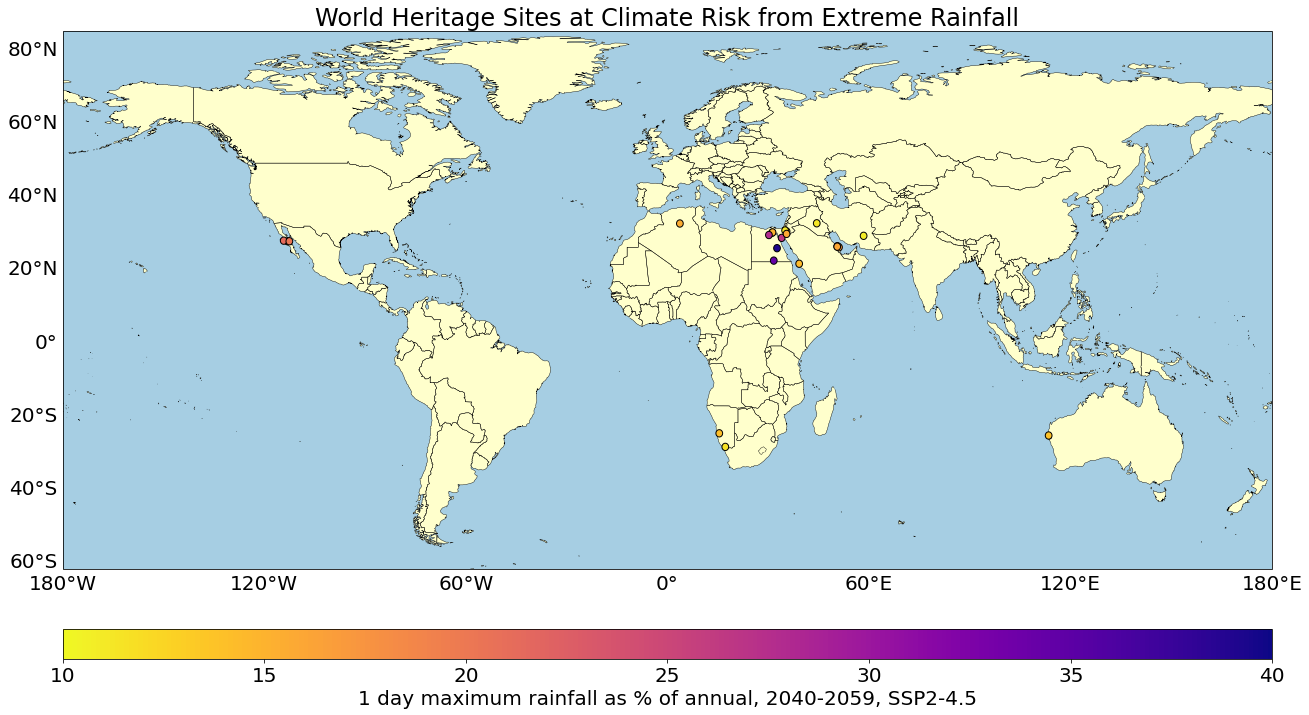

,Name,States,Category,Endangered,1 day maximum rainfall as % of annual
0,Ancient Thebes with its Necropolis,Egypt,Cultural,No,39
1,Nubian Monuments from Abu Simbel to Philae,Egypt,Cultural,No,34
2,Wadi Al-Hitan (Whale Valley),Egypt,Natural,No,28
3,Saint Catherine Area,Egypt,Cultural,No,27
4,Whale Sanctuary of El Vizcaino,Mexico,Natural,No,21
5,Islands and Protected Areas of the Gulf of California,Mexico,Natural,Yes,20
6,Rock Paintings of the Sierra de San Francisco,Mexico,Cultural,No,19
7,Al Zubarah Archaeological Site,Qatar,Cultural,No,17
8,Dilmun Burial Mounds,Bahrain,Cultural,No,16
9,Qal’at al-Bahrain – Ancient Harbour and Capital of Dilmun,Bahrain,Cultural,No,16


In [18]:
# Sitios afectados por precipitación extrema
i = 2

# Mapa
clim = pd.concat( [ cultural[cultural[cat_col_f[i][1]]],
    mixed[mixed[cat_col_f[i][1]]], natural[natural[cat_col_f[i][1]]] ] )
print(f"{i}, {clim[cat_col_f[i][0]].min()}, {clim[cat_col_f[i][0]].max()}")
min_v, max_v = 10, 40
map_clim = gv.Polygons( clim, vdims = gv.Dimension( cat_col_f[i][0],
    range = ( min_v, max_v ) ) ).opts( cmap = "plasma_r", **options )
map = ( ocean * countries * map_clim ).opts(
    title = "World Heritage Sites at Climate Risk from Extreme Rainfall",
    **options_m )
gv.output( map, size = 600 )

# Tabla con sitios más afectados
disp = clim.sort_values( cat_col_f[i][0], ascending = False
    ).reset_index(drop = True).head(10).copy()
disp = disp[ [ "name_en", "states_name_en",
    "category", "danger", cat_col_f[i][0] ] ]
disp.columns = [ "Name", "States",
    "Category", "Endangered", cat_col_f[i][0][:-21] ]
disp["Endangered"] = disp["Endangered"].where(
    disp["Endangered"] == 1, "No" )
disp["Endangered"] = disp["Endangered"].where(
    disp["Endangered"] == "No", "Yes" )
disp = disp.style.format( {cat_col_f[i][0][:-21]: "{:.0f}"} )
disp

In [19]:
# Resumen regional
regions = clim.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

,Region,Number of sites
0,Africa,2
1,Arab States,15
2,Asia and the Pacific,2
3,Europe and North America,1
4,Latin America and the Caribbean,3


3, 209.3482666015625, 299.159912109375


:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (min_zoom)
   .Path.I      :Path   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]   (100-year hurricane wind, 2040-2059, SSP2-4.5)
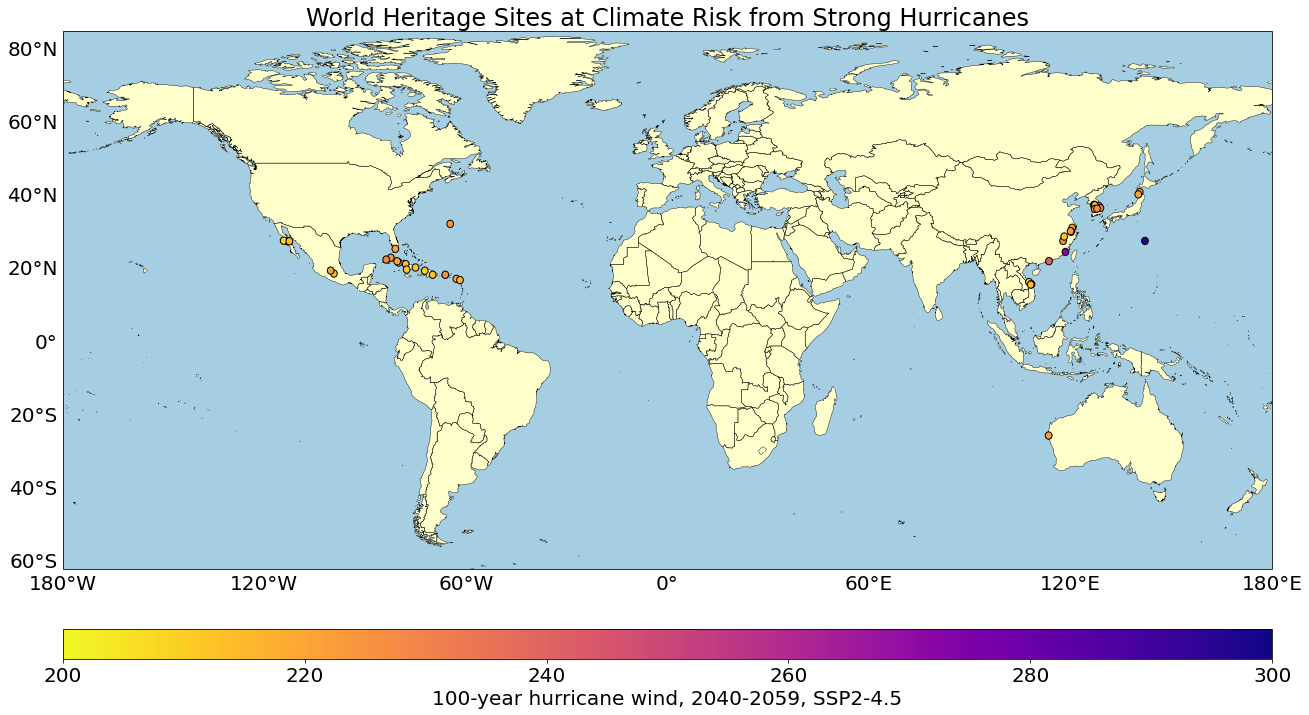

,Name,States,Category,Endangered,100-year hurricane wind
0,Ogasawara Islands,Japan,Natural,No,299
1,Quanzhou: Emporium of the World in Song-Yuan China,China,Cultural,No,272
2,Historic Centre of Macao,China,Cultural,No,240
3,"Seowon, Korean Neo-Confucian Academies",Republic of Korea,Cultural,No,230
4,West Lake Cultural Landscape of Hangzhou,China,Cultural,No,229
5,Viñales Valley,Cuba,Cultural,No,228
6,"Sansa, Buddhist Mountain Monasteries in Korea",Republic of Korea,Cultural,No,228
7,La Fortaleza and San Juan National Historic Site in Puerto Rico,United States of America,Cultural,No,226
8,Baekje Historic Areas,Republic of Korea,Cultural,No,225
9,Mount Wuyi,China,Mixed,No,225


In [20]:
# Sitios afectados por huracanes
i = 3

# Mapa
clim = pd.concat( [ cultural[cultural[cat_col_f[i][1]]],
    mixed[mixed[cat_col_f[i][1]]], natural[natural[cat_col_f[i][1]]] ] )
print(f"{i}, {clim[cat_col_f[i][0]].min()}, {clim[cat_col_f[i][0]].max()}")
min_v, max_v = 200, 300
map_clim = gv.Polygons( clim, vdims = gv.Dimension( cat_col_f[i][0],
    range = ( min_v, max_v ) ) ).opts( cmap = "plasma_r", **options )
map = ( ocean * countries * map_clim ).opts(
    title = "World Heritage Sites at Climate Risk from Strong Hurricanes",
    **options_m )
gv.output( map, size = 600 )

# Tabla con sitios más afectados
disp = clim.sort_values( cat_col_f[i][0], ascending = False
    ).reset_index(drop = True).head(10).copy()
disp = disp[ [ "name_en", "states_name_en",
    "category", "danger", cat_col_f[i][0] ] ]
disp.columns = [ "Name", "States",
    "Category", "Endangered", cat_col_f[i][0][:-21] ]
disp["Endangered"] = disp["Endangered"].where(
    disp["Endangered"] == 1, "No" )
disp["Endangered"] = disp["Endangered"].where(
    disp["Endangered"] == "No", "Yes" )
disp = disp.style.format( {cat_col_f[i][0][:-21]: "{:.0f}"} )
disp

In [21]:
# Resumen regional
regions = clim.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

,Region,Number of sites
0,Asia and the Pacific,22
1,Europe and North America,3
2,Latin America and the Caribbean,16


:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (min_zoom)
   .Path.I      :Path   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]   (danger)
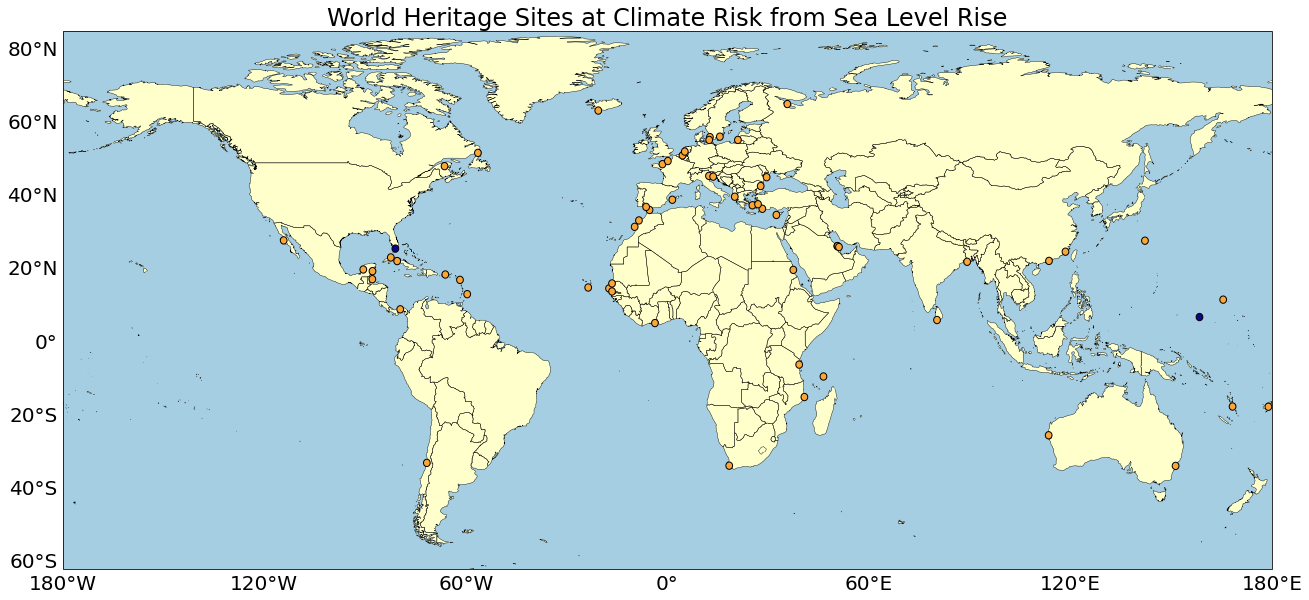

,Name,States,Category,Endangered,Drought,Extreme heat,Extreme rainfall,Strong Hurricanes,Sea level rise
0,Everglades National Park,United States of America,Natural,Yes,No,No,No,Yes,Yes
1,Nan Madol: Ceremonial Centre of Eastern Micronesia,Micronesia (Federated States of),Cultural,Yes,No,No,No,No,Yes
2,"Shark Bay, Western Australia",Australia,Natural,No,Yes,No,Yes,Yes,Yes
3,Qal’at al-Bahrain – Ancient Harbour and Capital of Dilmun,Bahrain,Cultural,No,No,Yes,Yes,No,Yes
4,"Pearling, Testimony of an Island Economy",Bahrain,Cultural,No,No,Yes,Yes,No,Yes
5,Al Zubarah Archaeological Site,Qatar,Cultural,No,No,Yes,Yes,No,Yes
6,Whale Sanctuary of El Vizcaino,Mexico,Natural,No,No,No,Yes,Yes,Yes
7,Old Havana and its Fortification System,Cuba,Cultural,No,No,No,No,Yes,Yes
8,La Fortaleza and San Juan National Historic Site in Puerto Rico,United States of America,Cultural,No,No,No,No,Yes,Yes
9,Medieval City of Rhodes,Greece,Cultural,No,Yes,No,No,No,Yes


In [22]:
# Sitios afectados por el aumento del nivel del mar

# Mapa
min_v, max_v = -0.25, 1
clim = pd.concat( [ cultural[cultural[cat_sl[1]]],
    mixed[mixed[cat_sl[1]]], natural[natural[cat_sl[1]]] ] )
map_clim = gv.Polygons( clim, vdims = gv.Dimension( "danger",
    range = ( min_v, max_v ) ) ).opts( cmap = "plasma_r",
    ylim = (-62,85), xlim = (-180,180) )
map = ( ocean * countries * map_clim ).opts(
    title = "World Heritage Sites at Climate Risk from Sea Level Rise",
    **options_m )
gv.output( map, size = 600 )

# Tabla con sitios más afectados
c = [ "Drought Hotspots, 2040-2059, SSP2-4.5",
    "Extreme temperature Hotspots, 2040-2059, SSP2-4.5",
    "Extreme rainfall Hotspots, 2040-2059, SSP2-4.5",
    "Hurricane Hotspots, 2040-2059, SSP2-4.5",
    "Sea level rise Hotspots, 2040-2059, SSP2-4.5" ]
c_2 = [ "Drought", "Extreme heat", "Extreme rainfall",
    "Strong Hurricanes", "Sea level rise" ]
disp = clim.sort_values( ["danger", "Count"], ascending = False
    ).reset_index(drop = True).head(10).copy()
disp = disp[ [ "name_en", "states_name_en", "category", "danger" ] + c]
disp.columns = [ "Name", "States", "Category", "Endangered" ] + c_2
disp["Endangered"] = disp["Endangered"].where(
    disp["Endangered"] == 1, "No" )
disp["Endangered"] = disp["Endangered"].where(
    disp["Endangered"] == "No", "Yes" )
disp[c_2] = disp[c_2].where( disp[c_2], "No" )
disp[c_2] = disp[c_2].where( disp[c_2] == "No", "Yes" )
disp

In [23]:
# Resumen regional
regions = clim.groupby("region_en").count().reset_index().iloc[:, 0:2]
regions.columns = ["Region", "Number of sites"]
regions

,Region,Number of sites
0,Africa,9
1,Arab States,6
2,Asia and the Pacific,11
3,Europe and North America,26
4,Latin America and the Caribbean,10
